# Notebook to open and view detections on audio:

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

## 2) Below are the functions for a) plotting an audio segment by itself and b) plotting an audio segment with detections overlayed

In [5]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

## 3) Below is usage of the above functions to open up files and see bat calls.
### This repository does not store audio files so file paths for audio files need to be replaced as relevant.
### There should be a corresponding detection file saved in output_dir under the corresponding recover-DATE folder and Location

In [6]:
df = pd.read_csv('../output_dir/recover-20240105/Central Pond/bd2__recover-20240105_UBNA_001.csv')

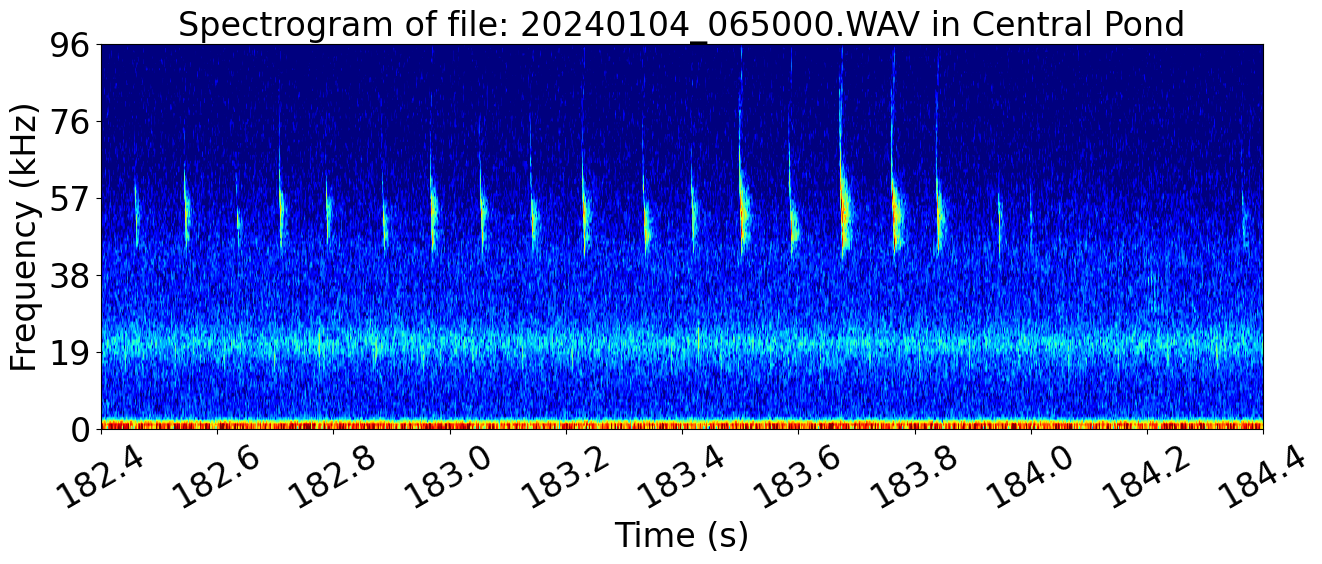

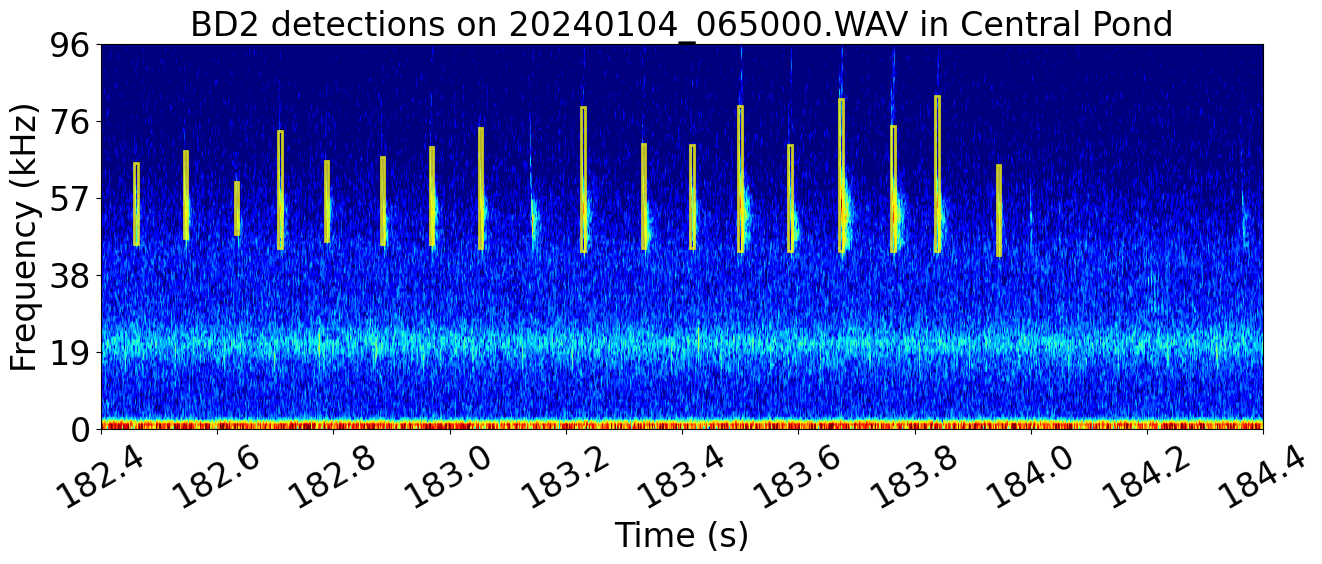

In [11]:
plot_file = Path('../../Downloads/recover-20240105/UBNA_001/20240104_065000.WAV')
# Below we filter our detections dataframe to only get the detections corresponding to the above audio file
plot_df = df.loc[pd.to_datetime(df['input_file'], format='%Y%m%d_%H%M%S', exact=False) == dt.datetime.strptime(plot_file.name, '%Y%m%d_%H%M%S.WAV')]
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 182.4
duration = 2
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
lower_dB = -40
upper_dB = 0
vmin = 20*np.log10(np.max(audio_seg)) + lower_dB # hide anything below lower_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + upper_dB # hide anything above upper_dB dB
audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 256 # When segments are short, NFFT should also be small to best see calls (must always be > 128)
spec_features['cmap'] = 'jet' # This colormap shows best contrast between noise and signals
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax

spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name} in Central Pond"
plot_audio_seg(audio_features, spec_features)
spec_features['plot_title'] = f"BD2 detections on {audio_features['file_path'].name} in Central Pond"
plot_dets_over_audio(audio_features, spec_features, plot_df)

## 4) Below is a usage of a basic function to run the batdetect2 pipeline on a single audio file
### The output can be saved as a csv or a .txt that is more useful for RavenPro visualizations
### The output will be saved in cfg['output_dir'] and any processing chunks will be stored in cfg['tmp_dir']

In [1]:
def run_pipeline_on_file(file, cfg):
    bd_preds = pd.DataFrame()

    if not cfg['output_dir'].is_dir():
        cfg['output_dir'].mkdir(parents=True, exist_ok=True)
    if not cfg['tmp_dir'].is_dir():
        cfg['tmp_dir'].mkdir(parents=True, exist_ok=True)

    if (cfg['run_model']):
        cfg["csv_filename"] = f"batdetect2_pipeline_{file.name.split('.')[0]}"
        print(f"Generating detections for {file.name}")
        segmented_file_paths = batdetect2_pipeline.generate_segmented_paths([file], cfg)
        file_path_mappings = batdetect2_pipeline.initialize_mappings(segmented_file_paths, cfg)
        bd_preds = batdetect2_pipeline.run_models(file_path_mappings)
        if cfg['save']:
            batdetect2_pipeline._save_predictions(bd_preds, cfg['output_dir'], cfg)
        batdetect2_pipeline.delete_segments(segmented_file_paths)

    return bd_preds

In [5]:
input_file = Path('../../Downloads/recover-20240105/UBNA_001/20240104_065000.WAV')

cfg = get_config()
cfg['input_audio'] = input_file
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = False
cfg['save'] = True

run_pipeline_on_file(input_file, cfg)

Generating detections for 20240104_065000.WAV


100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file
0,67.4535,67.4610,46953.0,62289.0,Echolocation,Pipistrellus pipistrellus,0.364,0.630,-1,../../Downloads/recover-20240105/UBNA_001/2024...
0,180.0315,180.0396,45234.0,60239.0,Echolocation,Pipistrellus pipistrellus,0.320,0.559,-1,../../Downloads/recover-20240105/UBNA_001/2024...
1,180.1285,180.1340,43515.0,53932.0,Echolocation,Pipistrellus pipistrellus,0.505,0.599,-1,../../Downloads/recover-20240105/UBNA_001/2024...
2,180.2225,180.2278,45234.0,52763.0,Echolocation,Pipistrellus pipistrellus,0.441,0.510,-1,../../Downloads/recover-20240105/UBNA_001/2024...
3,180.3115,180.3174,45234.0,56378.0,Echolocation,Pipistrellus pipistrellus,0.544,0.676,-1,../../Downloads/recover-20240105/UBNA_001/2024...
4,180.7675,180.7727,44375.0,60774.0,Echolocation,Pipistrellus pipistrellus,0.316,0.564,-1,../../Downloads/recover-20240105/UBNA_001/2024...
5,181.8625,181.8672,45234.0,59585.0,Echolocation,Pipistrellus pipistrellus,0.312,0.519,-1,../../Downloads/recover-20240105/UBNA_001/2024...
6,182.2465,182.2517,52109.0,64467.0,Echolocation,Pipistrellus pygmaeus,0.385,0.506,-1,../../Downloads/recover-20240105/UBNA_001/2024...
7,182.2985,182.3041,47812.0,71312.0,Echolocation,Pipistrellus pipistrellus,0.313,0.566,-1,../../Downloads/recover-20240105/UBNA_001/2024...
8,182.3615,182.3677,51250.0,65557.0,Echolocation,Pipistrellus pipistrellus,0.267,0.572,-1,../../Downloads/recover-20240105/UBNA_001/2024...


## 5) Below is an experiment where we plotted the detections for a 30-min in a certain section, then clipped that section and ran the detector on that section. The two detector outputs were different and thus, proved a non-deterministic characteristic of batdetect2

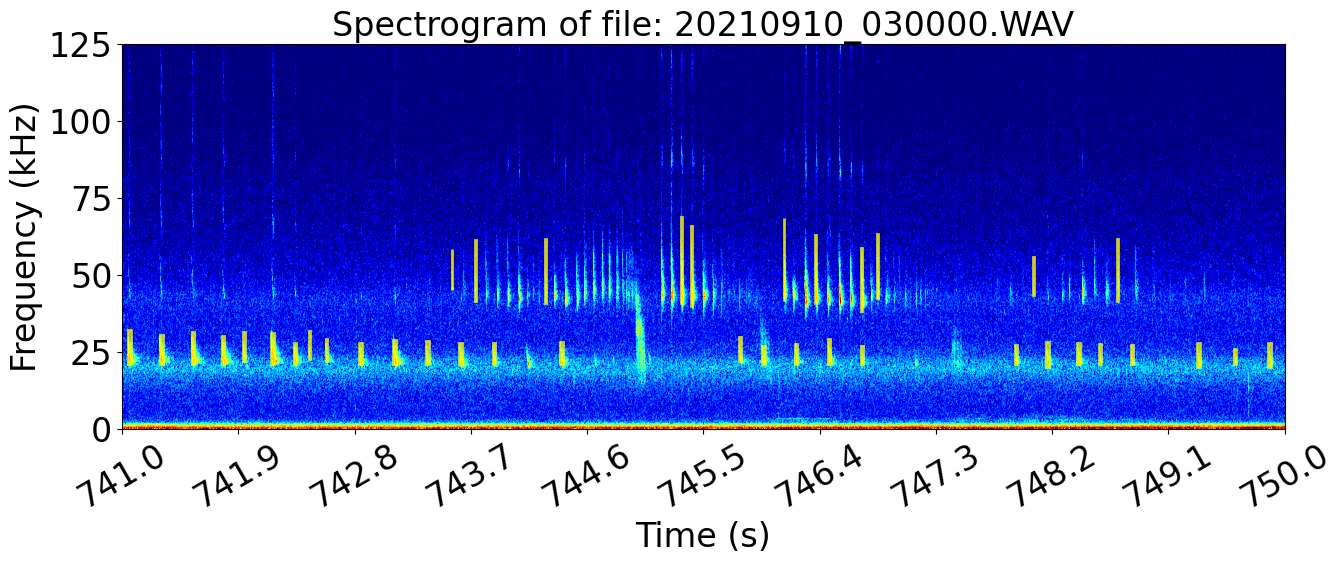

Generating detections for 20210910_030000_clipped741to750.WAV


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


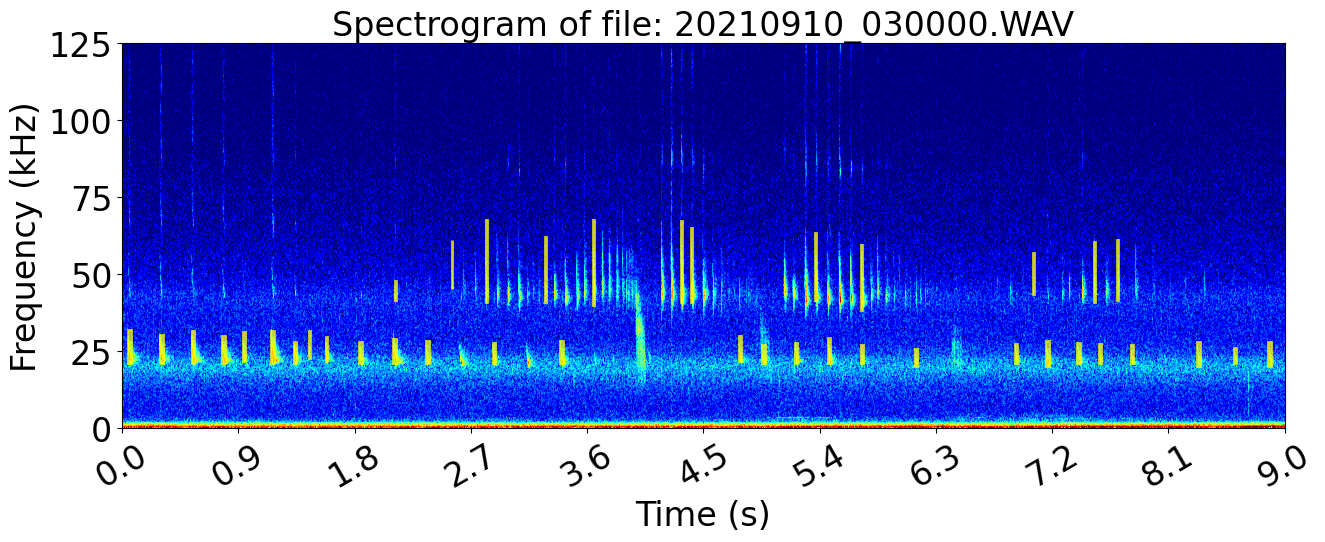

In [6]:
input_file = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file)
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

filename = input_file.name.split('.')[0]
original_file_dets = pd.read_csv(f'../output_dir/batdetect2_pipeline_{filename}.csv')

audio_file = sf.SoundFile(input_file)
fs = audio_file.samplerate
start = 741
duration = 9
end = int(start+duration)
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + 0 # hide anything below -rm_dB dB
write_file = f'../../Downloads/{filename}_clipped{start}to{end}.WAV'

audio_features = dict()
audio_features['file_path'] = input_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+duration))
original_plot_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, original_plot_dets)
sf.write(write_file, audio_seg, fs)

input_file = Path(write_file)

cfg = get_config()
cfg['input_audio'] = input_file
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

clipped_file_dets = batdetect2_pipeline.run_pipeline_on_file(input_file, cfg)

audio_file = sf.SoundFile(input_file)
fs = audio_file.samplerate
start = 0
audio_seg = audio_file.read()

audio_features = dict()
audio_features['file_path'] = input_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

window_cond = np.logical_and(clipped_file_dets['start_time'] > start, clipped_file_dets['end_time'] < (start+duration))
clipped_plot_dets = clipped_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, clipped_plot_dets)

clipped_plot_dets['start_time'] = 646+clipped_plot_dets['start_time']
clipped_plot_dets['end_time'] = 646+clipped_plot_dets['end_time']